In [ ]:
#PyDrive is a wrapper library of google-api-python-client that simplifies many common Google Drive API tasks
!pip install PyDrive

In [ ]:
import tensorflow as tf
import pandas as pd
import numpy as np
import json
from array import *
import random
from sklearn import ensemble
import math

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

https://drive.google.com/open?id=1mi3f0sJVsr46cv1YxEvs0KknWIXQ5efc

In [ ]:
#Get json file from drive link
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

downloaded = drive.CreateFile({'id':"1mi3f0sJVsr46cv1YxEvs0KknWIXQ5efc"}) #File ID from drive link
downloaded.GetContentFile('consolidatedData.json') #Name of file in drive

data_dict = json.load(open('consolidatedData.json')) #Read json file into dictionary object

In [ ]:
#Load data into 2D array
#[ticker, EPS, EPS_Estimate, EPS Growth %, %revenuegrowth, %Net Income Growth, %Change, NextDay%Change, %OvernightMovement(CloseVsOpen)]
data_array = []
for i in range (174):
    data_array.insert(i, [data_dict[i].get("data").get("attributes").get("company").get("ticker"), data_dict[i].get("data").get("attributes").get("result").get("EPS"), data_dict[i].get("data").get("attributes").get("result").get("EPS_Estimate"), data_dict[i].get("data").get("attributes").get("result").get("EPS Growth %"), data_dict[i].get("data").get("attributes").get("result").get("%RevenueGrowth"), data_dict[i].get("data").get("attributes").get("result").get("%Net Income Growth"), data_dict[i].get("data").get("attributes").get("result").get("%Change"), data_dict[i].get("data").get("attributes").get("result").get("NextDay%Change"), data_dict[i].get("data").get("attributes").get("result").get("%OvernightMovement(CloseVsOpen)")])

# Split into 80% training data and 20% testing data
random.shuffle(data_array)
train_data = data_array[:139]
test_data = data_array[139:]

#Split data into inputs [EPS_Estimate/EPS, EPS Growth %, %revenuegrowth, %Net Income Growth] and targets [%OvernightMovement(CloseVsOpen)]
train_input = []
target_output = []
for j in range (139):
    train_input.insert(j, [train_data[j][2]/train_data[j][1], train_data[j][3], train_data[j][4], train_data[j][5]])
    target_output.insert(j, train_data[j][8])

test_input = []
test_target = []
for k in range (35):
    test_input.insert(k, [train_data[j][2]/train_data[j][1], test_data[k][3], test_data[k][4], test_data[k][5]])
    test_target.insert(k, test_data[k][8])

Building model based on that of https://towardsdatascience.com/neural-networks-to-predict-the-market-c4861b649371

In [ ]:
# Generate MLP model, 2 hidden layers with 15 neurons each
model = tf.keras.models.Sequential()

#Input layer with input dimension of 7
model.add(tf.keras.layers.Dense(1, input_dim=7))

#Hidden layer with rectified linear activation
model.add(tf.keras.layers.Dense(15, activation=tf.nn.relu))

#Hidden layer with linear activation
model.add(tf.keras.layers.Dense(15))

#Output layer
model.add(tf.keras.layers.Dense(1))

#Using adam optimizer, could also use Adaptive Gradient Descent
#(AdaGrad) or Root Mean Square Propagation (RMSProp)
model.compile(optimizer="adam", loss="mse", metrics="accuracy")

#Train model
history = model.fit(train_input, target_output, epochs=50, validation_data=test_input)

#Test model
print("\nLoss value: ")
model.evaluate(test_input, test_target)

#Compare output to target values
test_results = model.predict(test_input)
for i in range (35):
    print("\nTest input: ", test_input[i])
    print("Target output: ", test_target[i])
    print("Model output: ", test_results[i])

result = math.sqrt(test_results^2 - test_target^2)

Epoch 1/50


ValueError: ignored

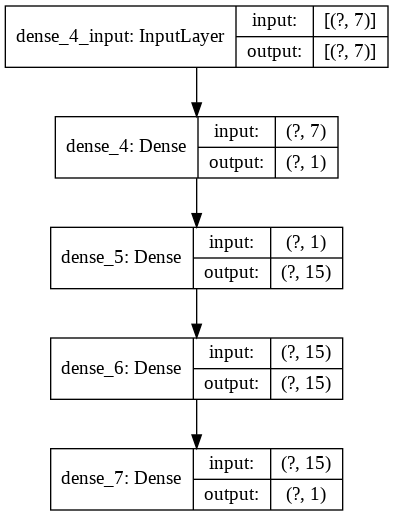

In [ ]:
from keras.utils import plot_model
tf.keras.utils.plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
import matplotlib.pyplot as plt

print(history.history.keys())

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='lower right')
plt.grid()
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
#plt.plot(result)
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.grid()
plt.show()

In [ ]:
clf = ensemble.GradientBoostingRegressor(n_estimators = 200, max_depth = 5, min_samples_split = 2, learning_rate = 0.01, loss = 'ls')
clf.fit(train_input, target_output)
clf.score(test_input,test_target) * -1
